In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import List, Tuple, Optional
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpy.lib.shape_base import column_stack
from tqdm.notebook import tnrange
import itertools

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve,auc, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tnrange, tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

In [ ]:
SEED = 42
DEBUG = True
np.random.seed(SEED)

In [ ]:
RESOURCES: str = '/content/drive/MyDrive/kaggle_repository'

In [ ]:
DATASET_PATH:str = '/content/drive/MyDrive/kaggle_repository/santander_dataset/train.csv'

# 0. Dataset

## A. (code)
Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the
original training set. 

**Answer**: I split the origial dataset in 3 parts, accordingly: 
 * Training set: A set of examples used for learning, that is to fit the parameters of the model (30 %).

 * Validation set: A set of examples used to tune the parameters of a model, for example to choose the best cut-off threshold,the step-size, the learning rate, etc... (20 %).

 * Test set: A set of examples used only to assess the performance of a fully-specified model (50 %).

 After that I found the best tuned parameters, I retrained the model over the "full" train dataset, namely Training set + Validation set (50 %). At the end I accessed the predictions/classifications over the Test set (50 %).

In [ ]:
features: List[str] = [f"var_{i}" for i in range(200)]
label: str = "target" 

In [ ]:
dataset_df = pd.read_csv(DATASET_PATH)
X_train, X_test,y_train, y_test  = train_test_split(dataset_df[features],dataset_df[label], test_size=0.5, random_state=SEED, stratify=dataset_df[label])
X_train, X_val,y_train, y_val = train_test_split(X_train,y_train,  test_size=0.2, random_state=SEED, stratify=y_train)

## B. (text) 
**Question**: comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.



**Answer:** 
The label distribution is strongly unbalanced: there are many samples labeled as negative and few samples of positive.
It affects the analysis, since the algorithms receive significantly more examples from one class, prompting it to be biased towards that particular class. They do not learn what makes the other class “different” and fails to understand the underlying patterns that allow us to distinguish classes.

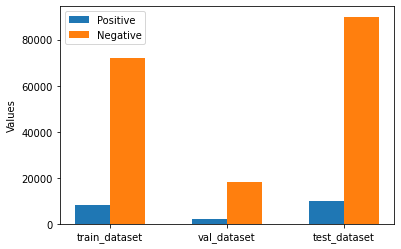

In [ ]:
labels = ['train_dataset', 'val_dataset', 'test_dataset']
positive = [len(y_train[y_train==1]),len(y_val[y_val==1]), len(y_test[y_test==1])]
negative = [len(y_train[y_train==0]),len(y_val[y_val==0]), len(y_test[y_test==0])]

x = np.arange(len(labels))
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, positive, width, label='Positive')
rects2 = ax.bar(x + width/2, negative, width, label='Negative')

ax.set_ylabel('Values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# 1. Bayesian Linear Regression

## 1.A. (code) 
Implement Bayesian linear regression (you should already have an implementation from the lab sessions) 

In [ ]:
class BayesianLinearRegression:
    
    def __init__(self, poly_order: int) -> None:
        self.w_posterior_mean: Optional[np.ndarray] = None
        self.w_posterior_cov: Optional[np.ndarray] = None
        self.K = poly_order

    def fit(self, X, y, sw2=1, sn2=1):
        X = self.build_features(X)
        S = np.diag(np.array([sw2]*X.shape[1]))
        S_inv = np.linalg.solve(S,np.identity(S.shape[0]))
        Sigma_inv = (1/sn2 * X.T@X + S_inv)
        Sigma =  np.linalg.solve(Sigma_inv,np.identity(Sigma_inv.shape[0]))

        self.w_posterior_mean = (1/sn2) * Sigma @ X.T@y
        self.w_posterior_cov = Sigma
    

    def predict(self,X):
        X = self.build_features(X)
        sn2 =1 
        def _compute_predictive_single_point(xt_i, sn2):
            yt_i_mean = xt_i.T @ self.w_posterior_mean
            yt_i_var = sn2 + xt_i.T@self.w_posterior_cov@xt_i
            return yt_i_mean, yt_i_var

        yt_mean, yt_var = np.zeros(len(X)), np.zeros(len(X))
        for i, xt_i in enumerate(X):  # Loop on all the points
            yt_mean[i], yt_var[i] = _compute_predictive_single_point(
                xt_i, sn2
            )

        return yt_mean, yt_var
    
    def build_features(self,x):
        row = [x**degree for degree in range(0,self.K+1)]
        features = column_stack(row)
        return features

## 1.B. (text)
**Question:** Describe any pre-processing that you suggest for this data

**Answer:**
As pre-processing I applied feature scaling, this allows more stability in the calculation, since the original feature range is very large, compared to the range of weights in the ML model. 


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 1.C. (code)
Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights 



### 1.C.1. 
Train on the Training Dataset

In [ ]:
linear_regr = BayesianLinearRegression(poly_order=2)
linear_regr.fit(X_train_scaled, y_train)

### 1.C.2. 
Predict on the Validation Dataset

In [ ]:
y_hat_mean, y_hat_var = linear_regr.predict(X_val_scaled)

## 1.D. (text)
Suggest a way to discretize predictions and display the confusion matrix on the
test data and report accuracy

In [ ]:
fpr, tpr, thresholds =roc_curve(y_val, y_hat_mean)
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]
roc_best = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
best_threshold = roc_best['thresholds'].item()
print(f"Best threshold: {best_threshold}")

Best threshold: 0.18396574333568297


### 1.D.1.  
Re Train on Train + Validation Dataset

In [ ]:
X_train_scaled_full = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_train_ful = np.concatenate([y_train, y_val], axis=0)
assert len(X_train_scaled_full) == len(X_test_scaled)

In [ ]:
linear_regr.fit(X_train_scaled_full, y_train_ful)

### 1.D.2. 
Predict on Test Dataset

In [ ]:
y_hat_mean, y_hat_var = linear_regr.predict(X_test_scaled)

In [ ]:
y_hat = y_hat_mean > best_threshold
print(f"Accuracy on Test: {accuracy_score(y_test, y_hat)}")
print(f"F1 on Test: {f1_score(y_test, y_hat)}")
print(f"AUC on Test: {roc_auc_score(y_test, y_hat)}")

Accuracy on Test: 0.80541
F1 on Test: 0.4546397242229758
AUC on Test: 0.8061805814005398


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=[5, 2])

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' - normalized'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f" % cm[i, j] if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.title(title, fontsize=20)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()

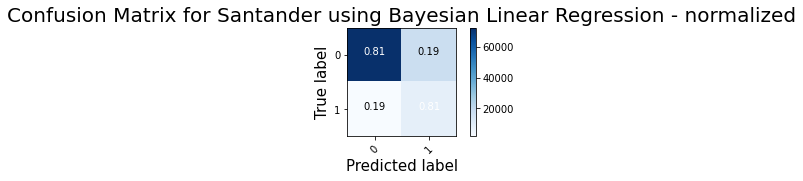

In [ ]:
lr_cm = confusion_matrix(y_true=y_test, y_pred=y_hat)
plot_confusion_matrix(lr_cm, classes=['0', '1'], title='Confusion Matrix for Santander using Bayesian Linear Regression',  normalize=True)


# 2. Bayesian Logistic Regression

## 2.A. (code)
The goal is to implement a Bayesian logistic regression classifier; assume a
Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters (you should already have an implementation
of the Metropolis-Hastings algorithm from the lab sessions). 

In [ ]:
class BayesianLogRegrMCMC:
    def __init__(self, n_samples, samples_path=None) -> None:
        self._n_accepted = 0
        self._n_samples = n_samples
        self._samples = None
        if samples_path:
            self._samples = np.load(samples_path)
            assert len(self.samples) == n_samples
    
    def save_samples(self, samples_path):
        np.save(samples_path, self._samples)

    def _rw_mh_step(self, X, y, w_prev, step_size):
        mu = np.zeros(len(w_prev))
        cov_matrix = np.eye(len(w_prev)) * step_size
        ws_tilde = w_prev + np.random.multivariate_normal(mean=mu, cov=cov_matrix)
        first_term = np.exp(BayesianLogRegrMCMC.logposterior(ws_tilde, X, y) - BayesianLogRegrMCMC.logposterior(w_prev, X, y))
        # notice that the second term is = 1 because of symmetry in Gaussians
        #second_term_numerator =  scipy.stats.multivariate_normal(mean=ws_tilde, cov=cov_matrix).pdf(w_prev) 
        #second_term_denominator = scipy.stats.multivariate_normal(mean=w_prev, cov=cov_matrix).pdf(ws_tilde) 
        second_term = 1 # second_term_numerator/second_term_denominator
        r = first_term * second_term
        w_next = ws_tilde if r >= 1 or r >= np.random.uniform(0, 1) else w_prev
        if not np.array_equal(w_next,w_prev):
            self._n_accepted+=1
        return w_next
    
    def fit(self,X,y,step_size,w_init)->None:
        w = np.atleast_1d(w_init)
        self._samples = np.empty((self._n_samples, *w.shape))
        for i in tnrange(self._n_samples, desc="Run Sampling"):
            w = self._rw_mh_step(X, y,w, step_size)
            self._samples[i] = w
    
    def fit_multiple_chains(self,X,y,n_chains,step_size,w_init)->None:
        w = np.atleast_1d(w_init)
        self._samples = np.empty((n_chains, self._n_samples, *w.shape))
        for i in range(n_chains):
            for j in range(self._n_samples):
                w = self._rw_mh_step(X, y,w, step_size)
                self._samples[i][j] = w
    

    def predict(self, Xt, n_samples=None):
        selected_idx = np.arange(len(self.samples))
        if n_samples and n_samples < len(self.samples):
            selected_idx = np.random.choice(a=len(self.samples),size=n_samples, replace=False)
        Xt = np.atleast_2d(Xt)
        samples = self.samples[selected_idx]
        return 1 / len(samples) * np.sum(BayesianLogRegrMCMC.logistic(samples @ Xt.T),axis=0)
    @property
    def n_accepted(self):
        return len(np.unique(self.samples,axis=0))
    @property
    def samples(self):
        #assert self._samples, "Call fit before get the samples"
        return self._samples

    @staticmethod
    def logposterior(w, X, y):
        logits = BayesianLogRegrMCMC.logistic(w.T @ X.T)
        log_ll = BayesianLogRegrMCMC.bernoulli_density(y,logits)
        prior = BayesianLogRegrMCMC.gaussian_density(w)
    
        return np.sum(log_ll) + np.sum(prior)

    @staticmethod
    def logistic(z):
        return 1 / (1 + np.exp(-z))   
    @staticmethod
    def bernoulli_density(y, p):
        # p[p==0] = 1e-10
        # p[p==1] = 1 - 1e-10
        p+=1e-10
        #assert np.all(p>0) and np.all(p<1), "Avoid log overflow"
        return y * np.log(p) + (1-y) * np.log(1-p) 
    
    @staticmethod
    def gaussian_density(x, mean=0, var=1):
        return - 0.5 * np.log(2 * np.pi * var) - 0.5 * (x - mean)**2 / var 

### 2.A.1.
Train on the Training dataset

In [ ]:
DEBUG = True
step_size = 1e-6
n_samples = 10000
n_features = X_train.shape[1]
w_init = np.zeros(n_features)
samples_path_train = RESOURCES+"/samples_train.npy"
if not DEBUG: 
    logistic_regr = BayesianLogRegrMCMC(n_samples=n_samples)
    logistic_regr.fit(X=X_train_scaled,y=y_train, step_size=step_size, w_init=w_init)
    logistic_regr.save_samples(samples_path=samples_path_train)
else:
    logistic_regr = BayesianLogRegrMCMC(n_samples=n_samples, samples_path=samples_path_train)

In [ ]:
logistic_regr.n_accepted

3521

### 2.A.2. 
Predict on the Validation Dataset

In [ ]:
logits_mh = logistic_regr.predict(X_val_scaled)

In [ ]:
fpr, tpr, thresholds =roc_curve(y_val, logits_mh)
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]
roc_best = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
best_threshold = roc_best['thresholds'].item()
print(f"Best threshold: {best_threshold}")
logits_mh = logits_mh > best_threshold
print(f"Accuracy on Validation: {accuracy_score(y_val, logits_mh)}")
print(f"F1 on Validation: {f1_score(y_val, logits_mh)}")
print(f"AUC on Validation: {roc_auc_score(y_val, logits_mh)}")

Best threshold: 0.571081063237071
Accuracy on Validation: 0.77665
F1 on Validation: 0.411384899196205
AUC on Validation: 0.77663530596047


## 2.A.3. 
Re Train on Train + Validation Dataset

In [ ]:
X_train_scaled_full = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_train_ful = np.concatenate([y_train, y_val], axis=0)
assert len(X_train_scaled_full) == len(X_test_scaled)

In [ ]:
DEBUG = True
samples_path_train_full = RESOURCES+"/samples_train_full.npy"
w_init = np.zeros(n_features)
if not DEBUG: 
    logistic_regr = BayesianLogRegrMCMC(n_samples=n_samples)
    logistic_regr.fit(X_train_scaled_full, y_train_ful, step_size=step_size, w_init=w_init)    
    logistic_regr.save_samples(samples_path=samples_path_train_full)
else:
    logistic_regr = BayesianLogRegrMCMC(n_samples=n_samples, samples_path=samples_path_train_full)

## 2.A.4 
Predict on Test Dataset

In [ ]:
logits_mh = logistic_regr.predict(X_test_scaled, n_samples=3000)

In [ ]:
final_logits_mh = logits_mh > best_threshold
print(f"Accuracy on Test: {accuracy_score(y_test, final_logits_mh)}")
print(f"F1 on Test: {f1_score(y_test, final_logits_mh)}")
print(f"AUC on Test: {roc_auc_score(y_test, logits_mh)}")

Accuracy on Test: 0.78293
F1 on Test: 0.41511060814269934
AUC on Test: 0.8581112048909227


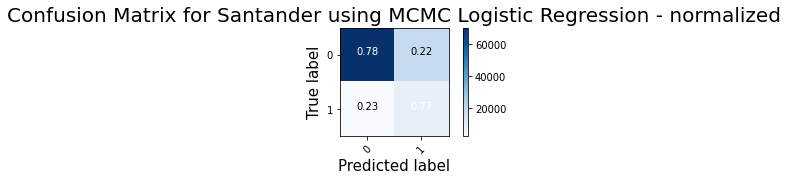

In [ ]:
lr_cm = confusion_matrix(y_true=y_test, y_pred=final_logits_mh)
plot_confusion_matrix(lr_cm, classes=['0', '1'], title='Confusion Matrix for Santander using MCMC Logistic Regression',  normalize=True)

## 2.B. (code)
 Implement the variational approximation we studied in the course to obtain an
approximation to the posterior over model parameters (you should already have an implementation of the from the lab sessions). 

In [ ]:
from functools import partial
from typing import NamedTuple


class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array

In [ ]:
def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """Compute the likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorize multiple MC samples automatically
        """
        # Get one sample of w using the sample_fn and the parameters of q
        w = sample_fn(rng, q_params)
        # Predict the output using the sample before
        yp = BayesianLogRegrVI.model(w,X)
        # Compute the likelihood and return it
        return likelihood_fn(y, yp)

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=1):
        """Computes the ELBO with multiple samples"""
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)

        # Compute the values of the likelihood
        likelihood_vals = likelihood_sample_fn(rng,q_params,X,y)
        # Compute the expectation (i.e. take the mean)
        expected_likelihood = 1/Nmc * jnp.sum(likelihood_vals)
        # Compute the KL divergence
        kl = kl_divergence_fn(q_params, p_params)
        # Compute the ELBO
        elbo = expected_likelihood - kl
        # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn

In [ ]:
class BayesianLogRegrVI:

    def __init__(self, sample_fn, likelihood_fn, kl_divergence_fn, q_params_path=None) -> None:
        self.rng = jax.random.PRNGKey(SEED)
        self._sample_fn = sample_fn
        self.elbo_fn = create_elbo_fn(
            sample_fn=sample_fn,
            kl_divergence_fn=kl_divergence_fn,
            likelihood_fn=likelihood_fn) 
        if q_params_path:
            with open(q_params_path, 'rb') as handle:
                self.q_params = pickle.load(handle)

    def fit(self,X,y,epochs=10000,Nmc=1000,lr=1e-4):
        n_features = X.shape[1]
        rng, rng2 = jax.random.split(self.rng)
        mean = jax.random.uniform(rng, shape=(n_features,))
        log_var = jnp.log(jax.random.uniform(rng2, shape=(n_features,)))

        p_params = GaussianDiagonal(mean, log_var)
        self.q_params =  p_params

        grad_elbo_fn = jax.grad(self.elbo_fn, has_aux=True)
        grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))

        elbo_summary = []
        lik_summary = []
        kl_summary = []
        rng = self.rng
        for i in tqdm(range(epochs), desc="Training ELBO"):
            rng, rng2 = jax.random.split(rng)
            q_params_grad, (likelihood, kl) = grad_elbo_fn(self.q_params, p_params, rng2, X,y,Nmc)
            self.q_params = BayesianLogRegrVI.sg_update(self.q_params, q_params_grad, lr)
            lik_summary.append(likelihood)
            kl_summary.append(kl)
            elbo_summary.append(likelihood - kl)


    
    def predict(self,Xt,Nmc=1000):

        def predict_y_single(rng):
            w = self._sample_fn(rng,self.q_params)
            yp = BayesianLogRegrVI.model(w,Xt)
            return yp

        rng = jax.random.split(self.rng,Nmc)
        Xt = jnp.atleast_1d(Xt)
        yp = jax.vmap(predict_y_single)(rng)
        # Take the mean
        yp = jnp.sum(yp,axis=0) * 1/Nmc
        return yp
    def save_q_params(self, q_params_path):
        with open(q_params_path, 'wb') as handle:
            pickle.dump(self.q_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

    @staticmethod
    def sg_update(params, gradients, learning_rate=1e-4):
        updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
        return updated_params
    @staticmethod
    def logistic(z):
        return 1 / (1 + jnp.exp(-z))
    
    @staticmethod
    def model(w, X):
        return BayesianLogRegrVI.logistic(X @ w)
    @staticmethod
    def kl_diag_diag(q_params, p_params):
        assert isinstance(q_params, GaussianDiagonal)
        assert isinstance(p_params, GaussianDiagonal)
        mean_q, log_var_q = q_params
        mean_p, log_var_p = p_params
        var_q = jnp.exp(log_var_q)
        var_p = jnp.exp(log_var_p)
        first_term = jnp.log(var_p/var_q)
        second_term = (var_q + (mean_q - mean_p)**2)/ var_p
        kl = 1/2 * jnp.sum(first_term+second_term -1)
        return kl

def sample_gaussian_diagonal(rng, params):
    mean, log_var = params
    var = jnp.exp(log_var)
    std = jnp.sqrt(var)
    eps = jax.random.normal(rng, shape=std.shape)
    return mean + eps*std
def kl_diag_diag(q_params, p_params):
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)
    mean_q, log_var_q = q_params
    mean_p, log_var_p = p_params
    var_q = jnp.exp(log_var_q)
    var_p = jnp.exp(log_var_p)
    first_term = jnp.log(var_p/var_q)
    second_term = (var_q + (mean_q - mean_p)**2)/ var_p
    kl = 1/2 * jnp.sum(first_term+second_term -1)
    return kl
def bernoulli_density(y, p):
    return y * jnp.log(p+1e-10) + (1 - y) * jnp.log(1 - p+1e-10)    

### 2.B.1.
Train on the Training dataset

In [ ]:
DEBUG = True
n_epochs = 10000
lr = 5e-6
q_params_train = RESOURCES+"/q_params_train.pkl"
if not DEBUG: 
    logistic_regr_vi = BayesianLogRegrVI(sample_fn=sample_gaussian_diagonal,likelihood_fn=bernoulli_density, kl_divergence_fn=kl_diag_diag)
    logistic_regr_vi.fit(X_train_scaled, y_train.to_numpy(), epochs=n_epochs, lr=lr)
    logistic_regr_vi.save_q_params(q_params_train)
else:
    logistic_regr_vi = BayesianLogRegrVI(sample_fn=sample_gaussian_diagonal,likelihood_fn=bernoulli_density, kl_divergence_fn=kl_diag_diag, q_params_path=q_params_train)

### 2.B.2. 
Predict on the Validation Dataset

In [ ]:
logits_vi = logistic_regr_vi.predict(X_val_scaled)

In [ ]:
fpr, tpr, thresholds =roc_curve(y_val, logits_vi)
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]
roc_best = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
best_threshold = roc_best['thresholds'].item()
print(f"Best threshold: {best_threshold}")
logits_vi = logits_vi > best_threshold
print(f"Accuracy on Validation: {accuracy_score(y_val, logits_vi)}")
print(f"F1 on Validation: {f1_score(y_val, logits_vi)}")
print(f"AUC on Validation: {roc_auc_score(y_val, logits_vi)}")

Best threshold: 0.5762597918510437
Accuracy on Validation: 0.77615
F1 on Validation: 0.410533245556287
AUC on Validation: 0.7759154477750215


## 2.B.3. 
Re Train on Train + Validation Dataset

In [ ]:
X_train_scaled_full = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)
assert len(X_train_scaled_full) == len(X_test_scaled)

In [ ]:
DEBUG = True
q_params_train_full = RESOURCES+"/q_params_train_full.pkl"
n_epochs = 10000
lr = 5e-6
if not DEBUG: 
    logistic_regr_vi = BayesianLogRegrVI(sample_fn=sample_gaussian_diagonal,likelihood_fn=bernoulli_density, kl_divergence_fn=kl_diag_diag)
    logistic_regr_vi.fit(X_train_scaled_full, y_train_full, epochs=n_epochs, lr=lr)
    logistic_regr_vi.save_q_params(q_params_train_full)
else:
    logistic_regr_vi = BayesianLogRegrVI(sample_fn=sample_gaussian_diagonal,likelihood_fn=bernoulli_density, kl_divergence_fn=kl_diag_diag, q_params_path=q_params_train_full)

## 2.B.4 
Predict on Test Dataset

In [ ]:
logits_vi = logistic_regr_vi.predict(X_test_scaled)

In [ ]:
final_logits_vi = logits_vi > best_threshold
print(f"Accuracy on Test: {accuracy_score(y_test, final_logits_vi)}")
print(f"F1 on Test: {f1_score(y_test, final_logits_vi)}")
print(f"AUC on Test: {roc_auc_score(y_test, logits_vi)}")

Accuracy on Test: 0.77964
F1 on Test: 0.41274917386206167
AUC on Test: 0.8576931247468719


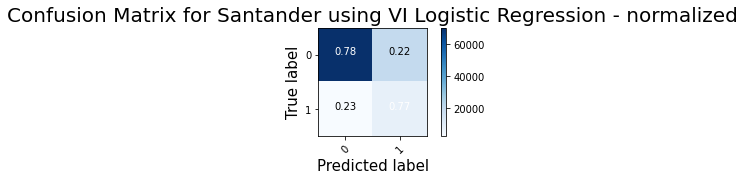

In [ ]:
lr_cm = confusion_matrix(y_true=y_test, y_pred=final_logits_vi)
plot_confusion_matrix(lr_cm, classes=['0', '1'], title='Confusion Matrix for Santander using VI Logistic Regression',  normalize=True)

## 2.D(text):
Comment on the tuning of the Metropolis-Hastings algorithm, and how to guaran-
tee that samples are representative of samples of the posterior over model parameters.

In [ ]:
#@title 2.D.1. Compute R-hat
def compute_rhat(samples):
    """Compute the rhat statistics from samples. Samples needs to be a tensor
    with dimensions [num_of_chain, num_of_samples, num_of_variables]."""

    def _rhat_base(ary):
        """Compute the rhat for a 2d array."""
        _, num_samples = ary.shape

        # Calculate chain mean
        chain_mean = np.mean(ary, axis=1)
        # Calculate chain variance
        chain_var = np.var(ary, axis=1, ddof=1)
        # Calculate between-chain variance
        between_chain_variance = num_samples * np.var(chain_mean, axis=None, ddof=1)
        # Calculate within-chain variance
        within_chain_variance = np.mean(chain_var)
        # Estimate of marginal posterior variance
        rhat_value = np.sqrt(
            (between_chain_variance / within_chain_variance + num_samples - 1)
            / (num_samples)
        )
        return rhat_value

    def _split_chains(ary):
        """Split and stack chains."""
        _, n_draw = ary.shape
        half = n_draw // 2
        return np.vstack((ary[:half], ary[-half:]))

    samples = np.atleast_3d(samples)
    return np.asarray(
        [_rhat_base(_split_chains(samples[..., i])) for i in range(samples.shape[-1])]
    )

In [ ]:
DEBUG = True
if not DEBUG:
    n_features = X_train.shape[1]
    w_inits = [np.zeros(n_features), np.random.rand(n_features)]
    for w_init in tqdm(w_inits, desc="w_init"):
        for step_size in tqdm([0.00001, 0.000001], desc="step_size"):
            logistic_regr = BayesianLogRegrMCMC(n_samples=10000)
            logistic_regr.fit_multiple_chains(X_train_scaled,y_train,n_chains=4, step_size=step_size, w_init=w_init)
            print(f"R_hat mean: {np.mean(compute_rhat(logistic_regr.samples))} - num_of_samples: {10000} - step_size: {step_size} - w_init: {w_init[:5]}")

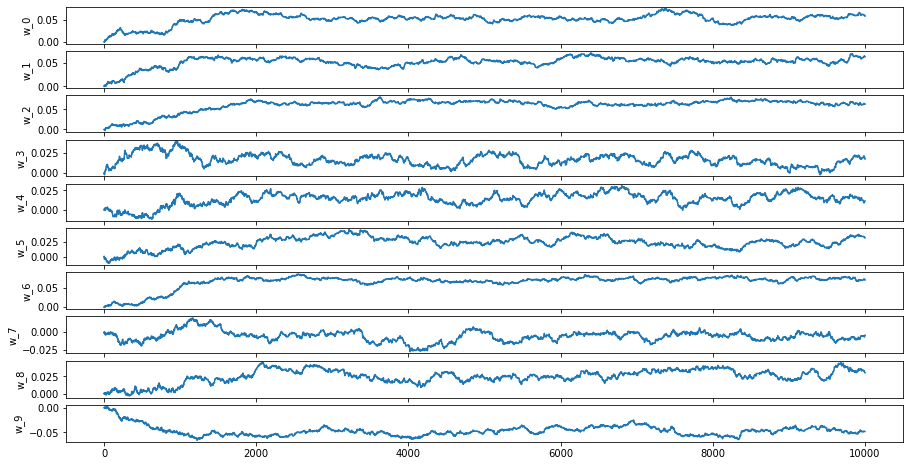

In [ ]:
fig, axes_tuple = plt.subplots(10, 1, figsize=[15, 8], sharex=True)

for i, ax in enumerate(axes_tuple):
  ax.plot(list(range(0, logistic_regr.samples.shape[0])), logistic_regr.samples[:, i])
  ax.set_ylabel(f'w_{i}')

plt.show()

For the model selection I started with the following configuration:

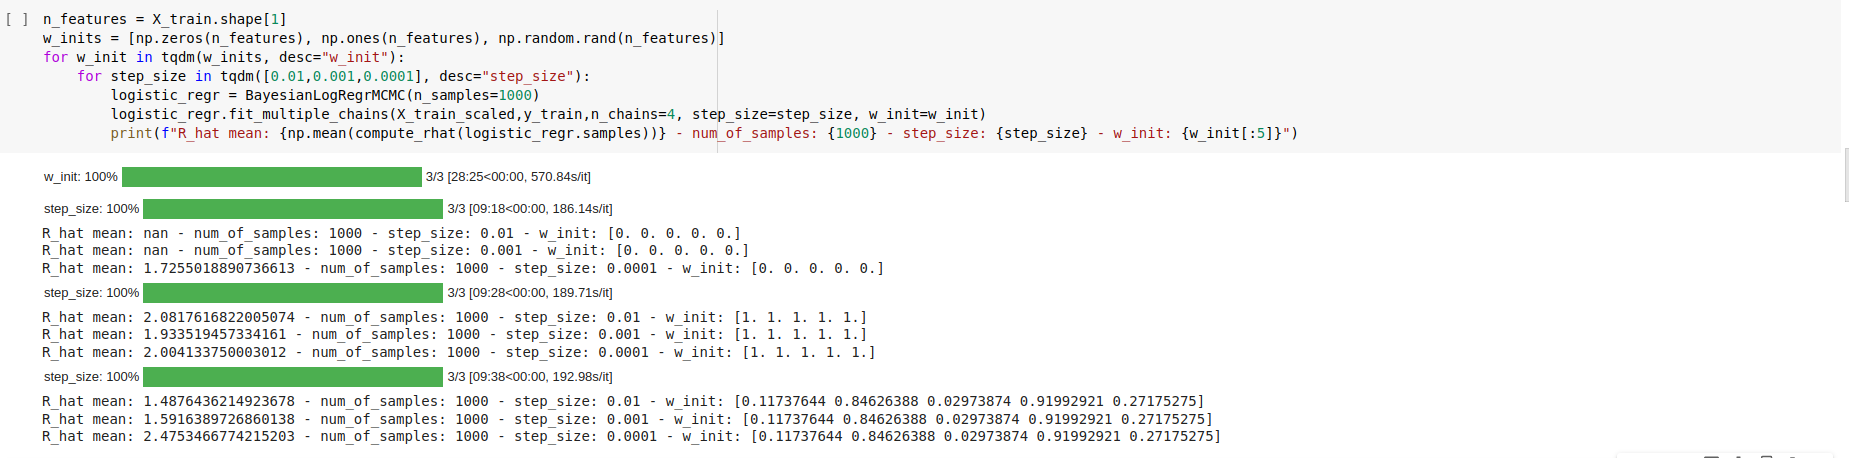

Then I moved to more refined one:
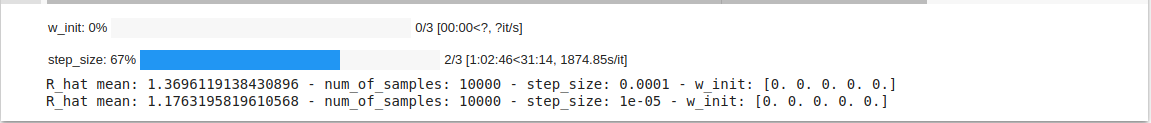

And finally I got the following best choice of `step_size = 1e-06`:
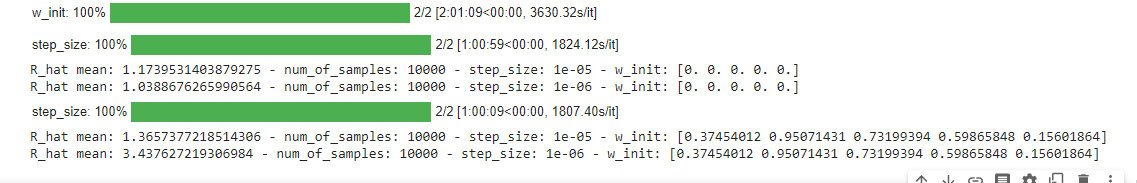

## 2.E.(text) 
Comment on the tuning of the variational inference algorithm, and discuss the behavior of the optimization with respect to the choice of the optimizer/step-size.

**Answer**: For variational infrence I tried different Learning Rates, until I found `lr=5e-6` the best choice on validation dataset.

## 2.F.(text)
Report the error metrics implemented in point 2.B. above and the confusion matrix on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression. 

## 2.G.(text)
Compare the uncertainties on predictions obtained by the Metropolis-Hastings
algorithm and variational inference. First, compare the log-likelihood on test data as a global metric to assess which inference method yields better uncertainty quantification.
Second, pick a few test points for which the mean of the predictive distribution for Metropolis-Hastings is: 
* (a) around 0.5;
* (b) giving a correct prediction; 
* (c) giving a wrong prediction.

Visualize/discuss what the predictive distribution looks like. Discuss the difference between the Metropolis-Hastings algorithm and variational inference. 

(a)

In [ ]:
def bernoulli_log_lik(y, p):
    return np.sum(y * np.log(p+1e-10) + (1-y) * np.log(1-p+1e-10))/np.prod(y.shape)

In [ ]:
print(f"Log-likelihood MCMC: {bernoulli_log_lik(y=y_test,p=logits_mh)}")

Log-likelihood MCMC: -0.658709412488509


In [ ]:
print(f"Log-likelihood Varitional Inference: {bernoulli_log_lik(y=y_test,p=logits_vi)}")

Log-likelihood Varitional Inference: -0.6584915404568613


In [ ]:
mask = np.logical_and(logits_mh>0.47, logits_mh<0.53)
logits_mh_fifty = logits_mh[mask]
mask = np.logical_and(logits_vi>0.47, logits_vi<0.53)
logits_vi_fifty  = logits_vi[mask]

[]

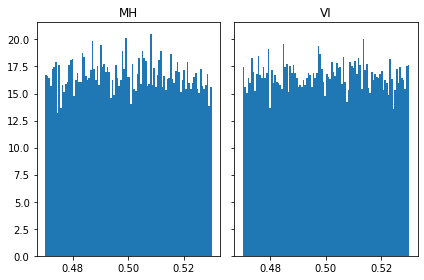

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(logits_mh_fifty, bins=n_bins, density=True)
axs[0].title.set_text('MH')
axs[1].hist(logits_vi_fifty, bins=n_bins, density=True)
axs[1].title.set_text('VI')
plt.plot()

(b)

In [ ]:
mask = y_test == final_logits_mh
logits_mh_correct = logits_mh[mask]
mask = y_test == final_logits_vi
logtis_vi_correct = logits_mh[mask]

[]

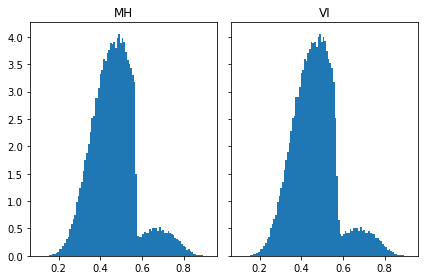

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(logits_mh_correct, bins=n_bins, density=True)
axs[0].title.set_text('MH')
axs[1].hist(logtis_vi_correct, bins=n_bins, density=True)
axs[1].title.set_text('VI')
plt.plot()

(c)

In [ ]:
mask = y_test != final_logits_mh
logits_mh_wrong = logits_mh[mask]
mask = y_test != final_logits_vi
logtis_vi_wrong = logits_mh[mask]

[]

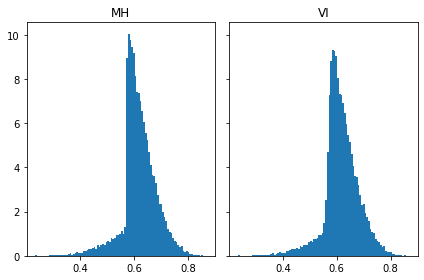

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(logits_mh_wrong, bins=n_bins, density=True)
axs[0].title.set_text('MH')
axs[1].hist(logtis_vi_wrong, bins=n_bins, density=True)
axs[1].title.set_text('VI')
plt.plot()

**Answer**:
For the Logistic regression models, it can be seen that the log likelihood is almost similar for all of them. Together with the 3 graphs (a), (b) and (c) this stands to mean that the distribution of weights obtained is using two different approaches (MH and VI) is approximately the same.
Moreover, (a) approximates a normal distribution (b) tends to be skewed toward the negative class, given the high number of negatively labeled samples. In contrast, prediction distribution (c) tends to be skewed toward the class 

# 3. Bonus questions

## A. (code/text)
Implement the Laplace approximation and compare the predictive mean and
variances with the ones obtained by the other approximations.

In [ ]:
import scipy.optimize
class BayesianLogRegLaplace:
    def __init__(self, w_map=None, hessian=None) -> None:
        self._w_map = w_map
        self._hessian = hessian
    
    def fit(self,X,y, w_init):
        solution = scipy.optimize.minimize(BayesianLogRegLaplace.neg_logposterior, w_init, args=(X, y), method='BFGS', options={'disp':True, 'maxiter':500})
        self._w_map = solution.x
        self._hessian = solution.hess_inv

    def predict(self,Xt, n_samples):
        samples = scipy.stats.multivariate_normal(mean=self._w_map, cov=self._hessian).rvs(size=n_samples)
        Xt = np.atleast_2d(Xt)
        return 1 / samples.shape[0] * np.sum(BayesianLogRegLaplace.logistic(samples @ Xt.T), axis=0)


    @staticmethod
    def neg_logposterior(w, X, y):
        y_hat = BayesianLogRegLaplace.logistic(X @ w)
        log_ll = BayesianLogRegLaplace.bernoulli_density(y,y_hat)
        prior = BayesianLogRegLaplace.gaussian_density(w)

        return - (np.sum(log_ll) + np.sum(prior))
    @staticmethod
    def logistic(z):
        return 1 / (1 + np.exp(-z))   
    @staticmethod
    def bernoulli_density(y, p):
        p+=1e-10
        #assert np.all(p>0) and np.all(p<1), "Avoid log overflow"
        return y * np.log(p) + (1-y) * np.log(1-p) 
    
    @staticmethod
    def gaussian_density(x, mean=0, var=1):
        return - 0.5 * np.log(2 * np.pi * var) - 0.5 * (x - mean)**2 / var 

In [ ]:
w_map_path = RESOURCES+"/w_map_train.npy"
heassian_path = RESOURCES+"/hessian_train.npy"
if not DEBUG:
    logistic_reg_laplace = BayesianLogRegLaplace()
    w_init = np.zeros(X_train.shape[1])
    logistic_reg_laplace.fit(X_train_scaled,y_train, w_init)
    np.save(w_map_path, logistic_reg_laplace._w_map)
    np.save(heassian_path, logistic_reg_laplace._hessian)
else:
    w_map = np.load(w_map_path)
    hessian = np.load(heassian_path)
    logistic_reg_laplace = BayesianLogRegLaplace(w_map=w_map, hessian=hessian)

In [ ]:
logits_laplace = logistic_reg_laplace.predict(X_val_scaled, n_samples=5000)

In [ ]:
fpr, tpr, thresholds =roc_curve(y_val, logits_laplace)
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]
roc_best = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
best_threshold = roc_best['thresholds'].item()
print(f"Best threshold: {best_threshold}")
logits_laplace = logits_laplace > best_threshold
print(f"Accuracy on Validation: {accuracy_score(y_val, logits_laplace)}")
print(f"F1 on Validation: {f1_score(y_val, logits_laplace)}")
print(f"AUC on Validation: {roc_auc_score(y_val, logits_laplace)}")

Best threshold: 0.5760561407113859
Accuracy on Validation: 0.77645
F1 on Validation: 0.4111681812195443
AUC on Validation: 0.7765241330866512


In [ ]:
w_map_path = RESOURCES+"/w_map_full_train.npy"
heassian_path = RESOURCES+"/hessian_full_train.npy"
if not DEBUG:
    logistic_reg_laplace = BayesianLogRegLaplace()
    w_init = np.zeros(X_train.shape[1])
    logistic_reg_laplace.fit(X_train_scaled_full,y_train_full, w_init)
    np.save(w_map_path, logistic_reg_laplace._w_map)
    np.save(heassian_path, logistic_reg_laplace._hessian)
else:
    w_map = np.load(w_map_path)
    hessian = np.load(heassian_path)
    logistic_reg_laplace = BayesianLogRegLaplace(w_map=w_map, hessian=hessian)

In [ ]:
logits_laplace = logistic_regr.predict(X_test_scaled, n_samples=3000)

In [ ]:
final_logits_laplace = logits_laplace > best_threshold
print(f"Accuracy on Test: {accuracy_score(y_test, final_logits_laplace)}")
print(f"F1 on Test: {f1_score(y_test, final_logits_laplace)}")
print(f"AUC on Test: {roc_auc_score(y_test, logits_laplace)}")

Accuracy on Test: 0.79164
F1 on Test: 0.4216078170108817
AUC on Test: 0.8581509673648915


In [ ]:
print(f"Log-likelihood Lapalce approx: {bernoulli_log_lik(y=y_test,p=logits_laplace)}")

Log-likelihood Lapalce approx: -0.6586438215966828


In [ ]:
print(f"Log-likelihood Varitional Inference: {bernoulli_log_lik(y=y_test,p=logits_vi)}")

Log-likelihood Varitional Inference: -0.6584915404568613


In [ ]:
print(f"Log-likelihood MCMC: {bernoulli_log_lik(y=y_test,p=logits_mh)}")

Log-likelihood MCMC: -0.658709412488509


In [ ]:
mask = np.logical_and(logits_mh>0.47, logits_mh<0.53)
logits_mh_fifty = logits_mh[mask]
mask = np.logical_and(logits_vi>0.47, logits_vi<0.53)
logits_vi_fifty  = logits_vi[mask]
mask = np.logical_and(logits_laplace>0.47, logits_laplace<0.53)
logits_laplace_fifty = logits_laplace[mask]

[]

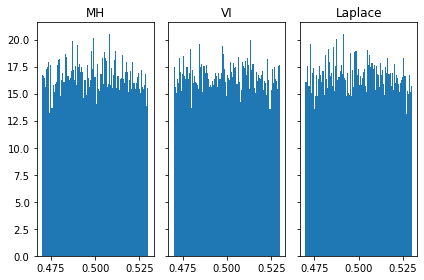

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(logits_mh_fifty, bins=n_bins, density=True)
axs[0].title.set_text('MH')
axs[1].hist(logits_vi_fifty, bins=n_bins, density=True)
axs[1].title.set_text('VI')
axs[2].hist(logits_laplace_fifty, bins=n_bins, density=True)
axs[2].title.set_text('Laplace')
plt.plot()

In [ ]:
mask = y_test == final_logits_mh
logits_mh_correct = logits_mh[mask]
mask = y_test == final_logits_vi
logtis_vi_correct = logits_mh[mask]
mask = y_test == final_logits_laplace
logtis_laplace_correct = logits_laplace[mask]

[]

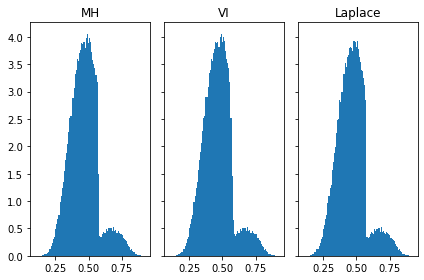

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(logits_mh_correct, bins=n_bins, density=True)
axs[0].title.set_text('MH')
axs[1].hist(logtis_vi_correct, bins=n_bins, density=True)
axs[1].title.set_text('VI')
axs[2].hist(logtis_laplace_correct, bins=n_bins, density=True)
axs[2].title.set_text('Laplace')
plt.plot()

In [ ]:
mask = y_test != final_logits_mh
logits_mh_wrong = logits_mh[mask]
mask = y_test != final_logits_vi
logtis_vi_wrong = logits_mh[mask]
mask = y_test != final_logits_laplace
logits_laplace_wrong = logits_laplace[mask]

[]

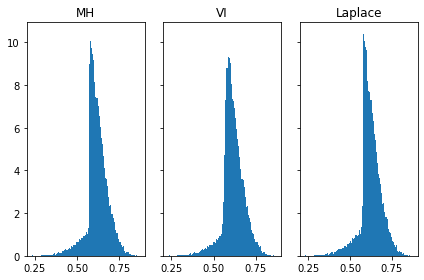

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(logits_mh_wrong, bins=n_bins, density=True)
axs[0].title.set_text('MH')
axs[1].hist(logtis_vi_wrong, bins=n_bins, density=True)
axs[1].title.set_text('VI')
axs[2].hist(logits_laplace_wrong, bins=n_bins, density=True)
axs[2].title.set_text('Laplace')
plt.plot()

**Answer**: 
As can be seen Laplace obtains the same results as the first two methods used to approximate the posterior distribution.

## B. (code/text) 
Suggest and implement ways to improve performance.
**Anseer**: To improve performance, it could help the use of techniques that try to rebalance the dataset, dimensionality reduction to reduce the number of features. Finally, if the featues would have been ``interpretable'' in their meaning (and not `var_i`) , with the help of experts sensible preprocessing would have made the difference.